In [1]:
%matplotlib inline
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


* Get the dataset from the Stata Press publishing house on their website.
* This gives a pandas series of the RGNP, and the index annotates the dates.

In [2]:
dta = pd.read_stata('https://www.stata-press.com/data/r14/rgnp.dta').iloc[1:]
dta.index = pd.DatetimeIndex(dta.date, freq='QS')
dta_hamilton = dta.rgnp

* Domestic recessions and expansions model.
* The model will include transition probabilities between these two regimes and predict probabilities of expansion or recession at each time point.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


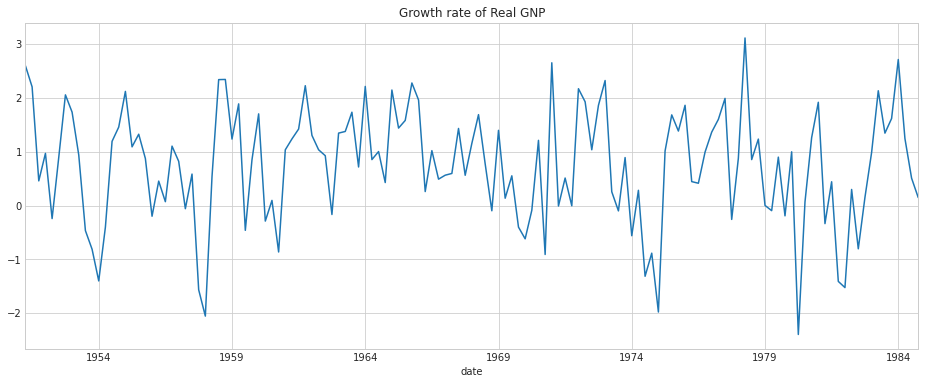

In [3]:
# Plot the data
dta_hamilton.plot(title='Growth rate of Real GNP', figsize=(16, 6))

* Fit the 4th order Markov switching model.
* Specify two regimes. 
* Get the model fitted via maximum likelihood estimation to the RGNP data.
* Set switching_ar=False because the statsmodels implementation defaults to
switching autoregressive coefficients.

In [4]:
# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(dta_hamilton, k_regimes=2, order=4, switching_ar=False)
res_hamilton = mod_hamilton.fit()

* See the regime transition parameters at the bottom of the same output.

In [5]:
print(res_hamilton.summary())

                         Markov Switching Model Results                         
Dep. Variable:                     rgnp   No. Observations:                  131
Model:             MarkovAutoregression   Log Likelihood                -181.263
Date:                  Tue, 30 Nov 2021   AIC                            380.527
Time:                          03:29:08   BIC                            406.404
Sample:                      04-01-1951   HQIC                           391.042
                           - 10-01-1984                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 

* See the lengths of recession and expansion.
* The output array is in financial quarters.
* Therefore, a recession is expected to take about four quarters (1 year) and an expansion 10 quarters (two and a half years).

In [6]:
res_hamilton.expected_durations

array([ 4.07604745, 10.42589387])

* Plot the probability of recession at each point in time.

In [7]:
from pandas_datareader.data import DataReader
from datetime import datetime
usrec = DataReader('USREC', 'fred', start=datetime(1947, 1, 1), end=datetime(2013, 4, 1))

* This gives a DataFrame in which recessions are indicated. 
* Here are the first five rows.
* In the first five rows, there was no recession according to the National Bureau of Economic Research (NBER) indicators.

In [8]:
usrec.head()

,USREC
DATE,
1947-01-01,0
1947-02-01,0
1947-03-01,0
1947-04-01,0
1947-05-01,0


* Plot NBER recession indicators against the model regime predictions.
* This gives actual recession data against model predictions.

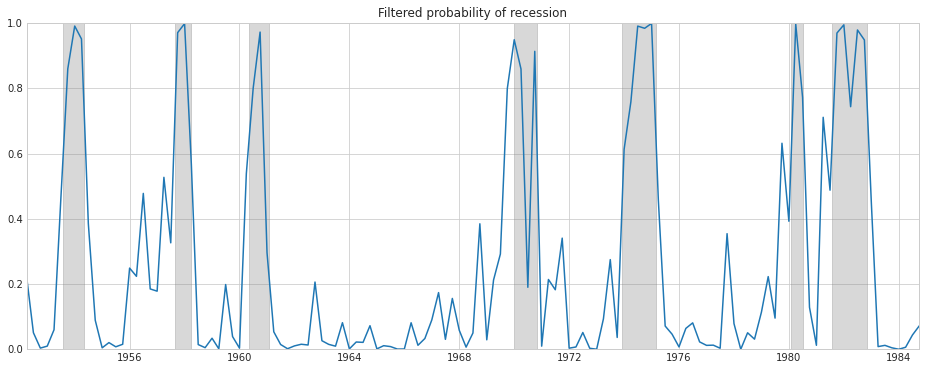

In [9]:
_, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.fill_between(
    usrec.index, 0, 1, where=usrec['USREC'].values,
    color='gray', alpha=0.3
)
ax.set(
    xlim=(dta_hamilton.index[4], dta_hamilton.index[-1]),
    ylim=(0, 1),
    title='Filtered probability of recession'
);

* See there seems to be quite a good match between the model predictions and
actual recession indicators.